##### Authors : BEN HASSEN Nadim, SABRA Ravi
# Projet DataMining
## Collecte de données
Tout d'abord, nous avons créé un dossier appelé Images.
Ensuite, nous avons téléchargé 100 images sur le theme de l'automobile sous licence ouverte ( à partir de Wikidata ) dans ce dossier.
Voici le code qui nous a permis d'accomplir ces étapes :

In [1]:
import requests
import os
import time

# Créer le dossier s'il n'existe pas déjà
folder_name = "Images"
os.makedirs(folder_name, exist_ok=True)

def get_car_images():
    # Requête pour récupérer les identifiants des voitures (automobiles) sur Wikidata avec les URL des médias Wikimedia
    query = """
    SELECT ?item ?itemLabel ?image
    WHERE {
      ?item wdt:P31 wd:Q1420;         # Instance of automobile
            wdt:P18 ?image.           # Image property
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
    }
    LIMIT 100
    """

    endpoint_url = "https://query.wikidata.org/sparql"
    headers = {'User-Agent': 'MyScript/1.0 (ravi.sabra@cpe.fr)'}

    response = requests.get(endpoint_url, headers=headers, params={'query': query, 'format': 'json'})
    data = response.json()

    images = [(item['itemLabel']['value'], item['image']['value'].replace('File:', 'Special:FilePath/')) for item in data['results']['bindings']]
    return images

def download_images(images):
    for i, (car_name, image_url) in enumerate(images):
        clean_car_name = ''.join(c if c.isalnum() or c.isspace() else '_' for c in car_name).strip().replace(' ', '_')
        if not image_url.startswith('http'):
            print(f"Échec du téléchargement de l'image {i+1} pour {car_name}. L'URL n'est pas valide.")
            continue

        response = requests.get(image_url, stream=True, headers={'User-Agent': 'MyScript/1.0 (ravi.sabra@cpe.fr)'})
        if response.status_code == 200:
            image_path = os.path.join(folder_name, f"{clean_car_name}_{i+1}.jpg")
            with open(image_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=128):
                    file.write(chunk)
            print(f"Image {i+1} téléchargée avec succès: {image_path}")
        else:
            print(f"Échec du téléchargement de l'image {i+1} pour {car_name}. Code d'erreur: {response.status_code}")

        time.sleep(1)  # Pause pour éviter le blocage par le serveur

if __name__ == "__main__":
    car_images = get_car_images()
    download_images(car_images)


Image 1 téléchargée avec succès: Images/Fiat_Perla_1.jpg
Image 2 téléchargée avec succès: Images/Fiat_Polski_132P_2.jpg
Image 3 téléchargée avec succès: Images/Fiat_Polski_518_3.jpg
Image 4 téléchargée avec succès: Images/Fiat_Regatta_4.jpg
Image 5 téléchargée avec succès: Images/Fiat_Steyr_126_5.jpg
Image 6 téléchargée avec succès: Images/Fiat_Steyr_500_6.jpg
Image 7 téléchargée avec succès: Images/Fiat_Grand_Siena_7.jpg
Image 8 téléchargée avec succès: Images/Funyo_4_RC_8.jpg
Image 9 téléchargée avec succès: Images/Gardner_Serpollet_Type_L_9.jpg
Image 10 téléchargée avec succès: Images/Gbaka_10.jpg
Image 11 téléchargée avec succès: Images/Geely_Jinying_11.jpg
Image 12 téléchargée avec succès: Images/Gemballa_Mirage_GT_12.jpg
Image 13 téléchargée avec succès: Images/Innocenti_C_13.jpg
Image 14 téléchargée avec succès: Images/Isotta_Fraschini_Tipo_8_14.jpg
Image 15 téléchargée avec succès: Images/Maruti_Dzire_15.jpg
Image 16 téléchargée avec succès: Images/Mercedes_Benz_SS_16.jpg
Image

### Métadata
Nous allons maintenant écrire un code qui enregistrera les métadonnées (EXIF) de chaque image, telles que la taille de l'image, le format de l'image (.jpeg, .png, etc.), l'orientation de l'image (paysage, portrait, carré, etc.), la date de création, le modèle d'appareil photo, etc., dans un fichier JSON nommé images_metadata.json.

In [2]:
from PIL import Image, ExifTags
import os
import json
from datetime import datetime

def get_exif_metadata(exif_data):
    if exif_data:
        exif_metadata = {}
        for tag, value in exif_data.items():
            tag_name = ExifTags.TAGS.get(tag, tag)  # Utilisation correcte des étiquettes Exif
            # Exclude problematic values
            if isinstance(value, bytes):
                continue
            # Convert non-serializable types to string
            if isinstance(value, (str, int, float)):
                exif_metadata[tag_name] = value
            else:
                exif_metadata[tag_name] = str(value)
        return exif_metadata
    return {}

def get_metadata(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()  # Get EXIF data
        metadata = {
            "image_name": os.path.basename(image_path),
            "image_size": img.size,
            "image_format": img.format,
            "image_orientation": get_image_orientation(exif_data),
            "creation_date": get_creation_date(exif_data),
            "exif_metadata": get_exif_metadata(exif_data),
        }
        return metadata

def get_image_orientation(exif_data):
    if exif_data:
        orientation = exif_data.get(274)  # 274 corresponds to the 'Orientation' tag
        if orientation is not None:
            return orientation
    return "Unknown"

def get_creation_date(exif_data):
    if exif_data:
        date_time_original = exif_data.get(36867)  # 36867 corresponds to 'DateTimeOriginal' tag
        if date_time_original is not None:
            try:
                # Convert the date string to a datetime object
                date_time_obj = datetime.strptime(date_time_original, '%Y:%m:%d %H:%M:%S')
                return date_time_obj.strftime('%Y-%m-%d')  # Format the date as desired
            except ValueError:
                # Gère le cas où la date ne correspond pas au format attendu
                print(f"Format de date non valide: {date_time_original}")
    return "Unknown"


def save_metadata_to_json(folder_path, output_file='images_metadata.json'):
    images_metadata = []
    for image_name in os.listdir(folder_path):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):  # Check the file extension to ensure it's an image
            image_path = os.path.join(folder_path, image_name)
            metadata = get_metadata(image_path)
            if metadata:
                images_metadata.append(metadata)
    
    with open(output_file, 'w') as file:
        json.dump(images_metadata, file, indent=4)

# Specify the folder containing the downloaded images
images_folder = './Images'

# Save metadata to JSON file
save_metadata_to_json(images_folder, 'images_metadata.json')


Format de date non valide: 2010:05:15 13:50:28 
Format de date non valide: 0000:00:00 00:00:00
Format de date non valide: 0000:00:00 00:00:00
Format de date non valide: 2013:06:09 14:45:41 


## Étiquetage et annotation
Pour cette tâche, nous avons écrit un code qui extrait les trois couleurs dominantes de chaque image à l'aide de l'algorithme de clustering KMeans. Ensuite, nous avons créé un fichier JSON nommé image_data.json où nous avons enregistré les informations telles que la taille de l'image, son orientation, ses trois couleurs prédominantes et éventuellement sa date de création. Enfin, ce processus peut être étendu pour intégrer des tags supplémentaires, permettant ainsi une meilleure classification des images.

In [3]:
from PIL import Image, ExifTags
import numpy as np
from sklearn.cluster import KMeans
import os
import json
from scipy.spatial import distance
from datetime import datetime

def extract_dominant_colors(image_path, num_colors=3, min_image_size=(100, 100)):
    try:
        # Ouvrir l'image
        image = Image.open(image_path)
        
        # Vérifier la taille minimale de l'image
        if image.size < min_image_size:
            print(f"Ignoring {image_path} because it's too small.")
            return None
        
        # Convertir l'image en tableau numpy
        image_array = np.array(image)
        
        # Redimensionner l'image pour accélérer le processus de clustering
        resized_image_array = image_array.reshape(-1, 3)
        
        # Effectuer le clustering KMeans sur les pixels de l'image
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(resized_image_array)
        
        # Récupérer les centres de cluster
        dominant_colors = kmeans.cluster_centers_.astype(int)
        
        return dominant_colors.tolist()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


def assign_color_names(colors):
    # Correspondance des couleurs connues en RGB
    color_ranges = {
        "Noir": [0, 0, 0],
        "Blanc": [255, 255, 255],
        "Rouge": [255, 0, 0],
        "Vert": [0, 255, 0],
        "Bleu": [0, 0, 255],
        "Jaune": [255, 255, 0],
        "Magenta": [255, 0, 255]
    }
    
    closest_colors = []
    for color in colors:
        # Comparaison des couleurs avec les couleurs connues en utilisant la distance euclidienne dans l'espace RGB
        min_distance = float('inf')
        closest_color = "Autre"
        for color_name, color_rgb_known in color_ranges.items():
            distance_rgb = distance.euclidean(color, color_rgb_known)
            if distance_rgb < min_distance:
                min_distance = distance_rgb
                closest_color = color_name
        closest_colors.append(closest_color)
            
    return closest_colors

def get_image_size(image_path):
    # Ouvrir l'image et obtenir sa taille
    image = Image.open(image_path)
    return image.size

def get_image_orientation(image_path):
    # Ouvrir l'image et obtenir son orientation à partir des métadonnées EXIF
    try:
        with Image.open(image_path) as img:
            exif_data = img._getexif()
            if exif_data:
                orientation = exif_data.get(274, None)
                if orientation == 3:
                    return "Paysage inversé"
                elif orientation == 6:
                    return "Paysage"
                elif orientation == 8:
                    return "Portrait"
    except (AttributeError, KeyError, IndexError):
        pass
    
    # Si l'orientation n'a pas été trouvée dans les métadonnées EXIF, calculons l'orientation en fonction des dimensions de l'image
    image_size = get_image_size(image_path)
    if image_size[0] > image_size[1]:
        return "Paysage"
    elif image_size[0] < image_size[1]:
        return "Portrait"
    else:
        return "Carré"

def cluster_images(image_folder, output_file='image_data.json', num_colors=3):
    image_data = {}
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            colors = extract_dominant_colors(image_path, num_colors)
            if colors is not None:  # Vérifier si les couleurs sont non nulles
                color_names = assign_color_names(colors)
                image_size = get_image_size(image_path)
                image_orientation = get_image_orientation(image_path)
                image_data[filename] = {'dominant_colors': color_names,
                                        'image_size': image_size,
                                        'orientation': image_orientation}
                # Ajouter la date de création si elle est disponible
                try:
                    with Image.open(image_path) as img:
                        exif_data = img._getexif()
                        if exif_data:
                            creation_date = exif_data.get(36867)  # 36867 corresponds to 'DateTimeOriginal' tag
                            if creation_date:
                                # Vérifier si la chaîne de date est valide
                                if isinstance(creation_date, str) and creation_date.strip():
                                    creation_date = datetime.strptime(creation_date.strip(), '%Y:%m:%d %H:%M:%S').strftime('%Y-%m-%d')
                                    image_data[filename]['creation_date'] = creation_date
                                else:
                                    image_data[filename]['creation_date'] = 'Unknown'
                        else:
                            image_data[filename]['creation_date'] = 'Unknown'
                except (AttributeError, KeyError, IndexError, ValueError) as e:
                    image_data[filename]['creation_date'] = 'Unknown'
                    print(f"Error processing {image_path}: {e}")
    
    # Écrire les résultats dans un fichier JSON
    with open(output_file, 'w') as file:
        json.dump(image_data, file, indent=4)


# Exemple d'utilisation
cluster_images('Images', 'image_data.json', num_colors=3)

Error processing Images/Moskwicz_420_422_69.jpg: unconverted data remains:  
Error processing Images/Dodge_Sprinter_70.jpg: time data '0000:00:00 00:00:00' does not match format '%Y:%m:%d %H:%M:%S'
Error processing Images/Subaru_B5_TPH_21.jpg: time data '0000:00:00 00:00:00' does not match format '%Y:%m:%d %H:%M:%S'
Error processing Images/Daimler_Schroedter_Wagen_33.jpg: unconverted data remains:  
Error processing Images/Trevethan_60.jpg: cannot reshape array of size 727000 into shape (3)


## Analyses de données
Le programme permet aux utilisateurs de sélectionner des images. En analysant les images sélectionnées, il génère automatiquement les préférences des utilisateurs, telles que leurs couleurs préférées, leur orientation d'image préférée et leurs tailles d'images préférées. Ces informations sont ensuite enregistrées dans un fichier JSON pour chaque utilisateur.

In [2]:
import ipywidgets as widgets
from os import listdir
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import json

def get_user_info():
    num_users = int(input("Enter the number of users: "))
    user_names = [input(f"Enter the name of user {i+1}: ") for i in range(num_users)]
    return user_names

def select_images(user_name, images, on_selection_done):
    checkboxes = [widgets.Checkbox(value=False, description=image.split('/')[-1]) for image in images]
    button = widgets.Button(description="Select")
    output = widgets.Output()
    layout = widgets.GridspecLayout(n_columns=2, n_rows=len(images))
    
    for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
        with open(img, "rb") as file:
            image_widget = widgets.Image(value=file.read(), format='jpg', width=100, height=100)
        layout[i, 0], layout[i, 1] = image_widget, checkbox
    
    def on_button_clicked(b):
        selected_images = [checkbox.description for checkbox in checkboxes if checkbox.value]
        on_selection_done(user_name, selected_images)
        
    button.on_click(on_button_clicked)
    display(layout, button, output)

with open('image_data.json', 'r') as file:
    image_colors = json.load(file)

def on_images_selected(user_name, selected_images):
    df = pd.DataFrame.from_dict(image_colors, orient='index')
    df_selected = df.loc[selected_images]

    # Process dominant colors
    mlb = MultiLabelBinarizer()
    colors = mlb.fit_transform(df_selected['dominant_colors'])
    color_counts = colors.sum(axis=0)
    top_three_colors = mlb.classes_[color_counts.argsort()[-3:]].tolist()

    # Preferred orientation
    preferred_orientation = df_selected['orientation'].mode().iloc[0]

    # Average image size
    average_size = df_selected['image_size'].apply(pd.Series).mean().round().astype(int).tolist()

    user_preferences[user_name] = {
        "selected_images": selected_images,
        "favorite_colors": top_three_colors,
        "preferred_orientation": preferred_orientation,
        "average_image_size": average_size,
    }

    with open("user_preferences.json", "w") as file:
        json.dump(user_preferences, file, indent=4)
    print(f"Preferences saved for {user_name}: {user_preferences[user_name]}")

user_names = get_user_info()
user_preferences = {}
images = ["Images/" + file for file in listdir("Images") if file.endswith(".jpg")]

for name in user_names:
    print(f"Select images for {name}:")
    select_images(name, images, on_images_selected)


Select images for Nadim:


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xf…

Button(description='Select', style=ButtonStyle())

Output()

Preferences saved for Nadim: {'selected_images': ['Gurgel_XEF_64.jpg', 'Daihatsu_Fellow_Buggy_66.jpg', 'Triumph_TR2_3_73.jpg', 'Shelby_GT_350_87.jpg', 'Ferrari_Dino_246_S_47.jpg', 'Citroën_Wild_Rubis_83.jpg', 'Gurgel_Tocantins_63.jpg', 'Anadol_STC_16_52.jpg', 'Gurgel_X_15_65.jpg', 'Alfa_Romeo_Quadrifoglio_24.jpg', 'Fiat_Steyr_500_6.jpg'], 'favorite_colors': ['Rouge', 'Blanc', 'Noir'], 'preferred_orientation': 'Paysage', 'average_image_size': [1366, 997]}


## Visualisation des données
Ce programme utilise la bibliothèque Matplotlib pour visualiser les données relatives aux images téléchargées. Il présente d'abord un histogramme du nombre d'images disponibles pour chaque année de création. Ensuite, il affiche la distribution des couleurs prédominantes dans toutes les images, et enfin, il permet aux utilisateurs de visualiser les caractéristiques de leurs propres images préférées, telles que les années de création, les couleurs dominantes et les orientations.

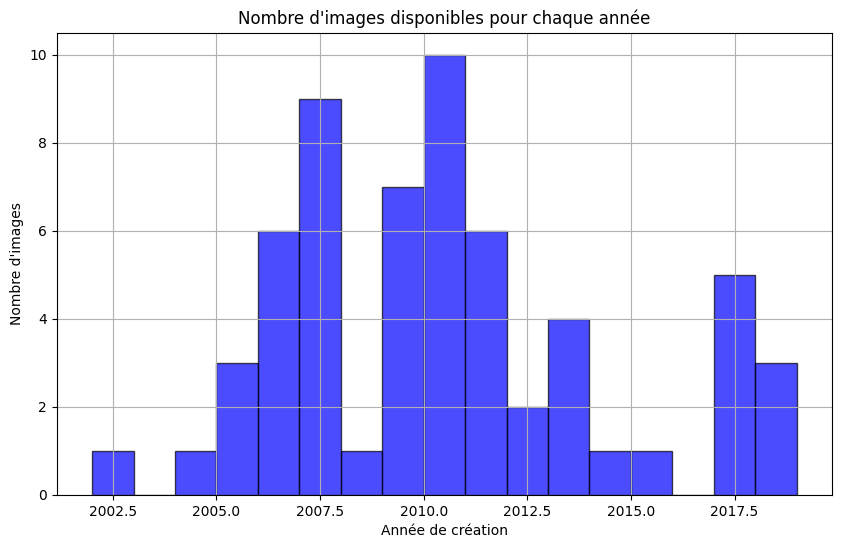

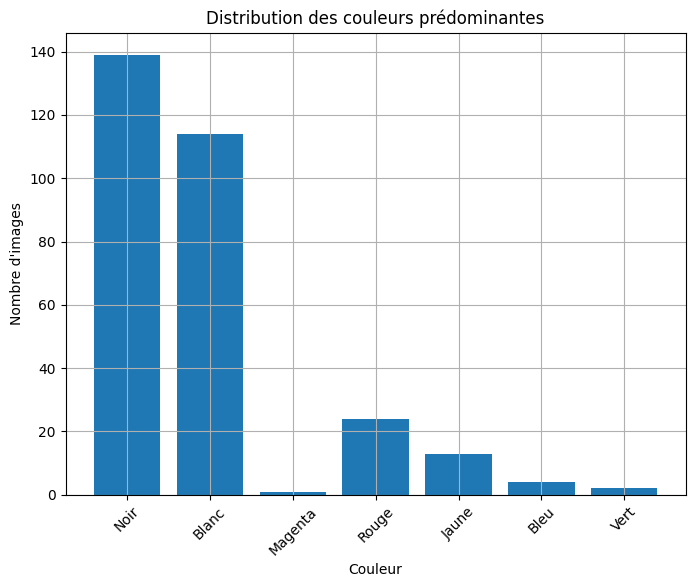

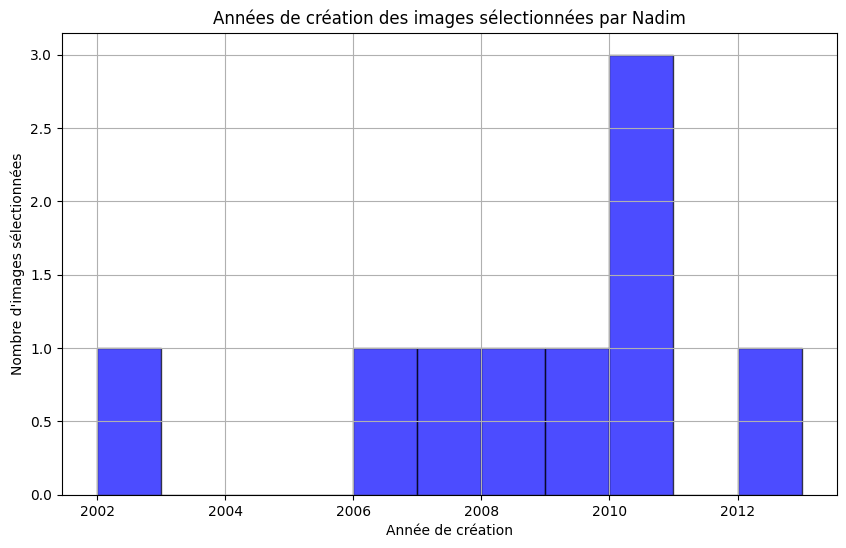

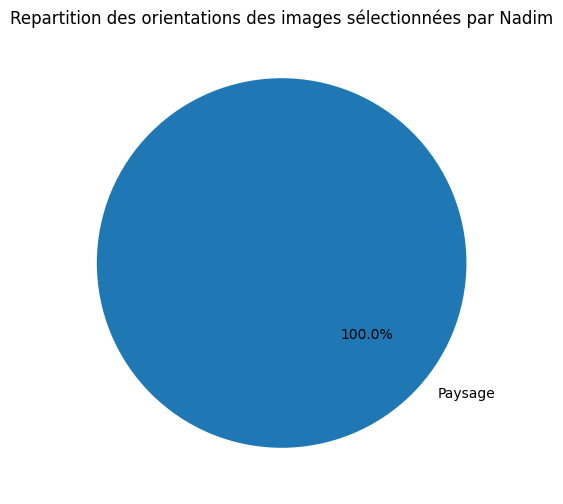

In [3]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Chargement des données sur les images
with open('image_data.json', 'r') as file:
    image_data = json.load(file)


# Chargement des données sur les préférences des utilisateurs
with open('user_preferences.json', 'r') as user_prefs_file:
    user_preferences = json.load(user_prefs_file)


def extract_year(image):
    if 'creation_date' in image and image['creation_date'] != "Unknown":
        return int(image['creation_date'].split('-')[0])
    else:
        return None
    
# Extraction des années de création des images
image_years = [extract_year(image_data[image]) for image in image_data if extract_year(image_data[image]) is not None]

# Filtrer les valeurs None de la liste image_years
image_years_filtered = [int(year) for year in image_years if year is not None]

# Vérifier si la liste des années filtrées est vide
if not image_years_filtered:
    print("Aucune année de création n'est disponible pour les images chargées.")
else:
    # Création d'un histogramme pour le nombre d'images disponibles pour chaque année
    plt.figure(figsize=(10, 6))
    plt.hist(image_years_filtered, bins=range(min(image_years_filtered), max(image_years_filtered) + 1), alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Année de création')
    plt.ylabel("Nombre d'images")
    plt.title("Nombre d'images disponibles pour chaque année")
    plt.grid(True)
    plt.show()

    # Visualisation des caractéristiques des couleurs
    all_colors = [color for image in image_data for color in image_data[image]['dominant_colors']]
    color_counts = Counter(all_colors)

    plt.figure(figsize=(8, 6))
    plt.bar(color_counts.keys(), color_counts.values())
    plt.xlabel('Couleur')
    plt.ylabel("Nombre d'images")
    plt.title("Distribution des couleurs prédominantes")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Visualisation des informations relatives aux images préférées des utilisateurs
def visualize_user_profile(user_name):
    if user_name in user_preferences:
        user_profile = user_preferences[user_name]
        selected_images = user_profile['selected_images']

        # Extract years for selected images
        image_years = [extract_year(image_data[image]) for image in selected_images if extract_year(image_data[image]) is not None]

        # Filtrer les valeurs None de la liste image_years
        image_years_filtered = [int(year) for year in image_years if year is not None]
        
        # Visualize the histogram of creation years for selected images
        # Vérifier si la liste des années filtrées est vide
        if not image_years_filtered:
            print(f"Aucune information sur l'année de création pour les images sélectionnées par {user_name}.")
        else:
            plt.figure(figsize=(10, 6))
            plt.hist(image_years_filtered, bins=range(min(image_years_filtered), max(image_years) + 1), alpha=0.7, color='blue', edgecolor='black')
            plt.xlabel('Année de création')
            plt.ylabel("Nombre d'images sélectionnées")
            plt.title(f"Années de création des images sélectionnées par {user_name}")
            plt.grid(True)
            plt.show()
        

        # Visualize the color distribution for selected images
        all_colors = [color for image in selected_images for color in image_data[image]['dominant_colors']]
        color_counts = Counter(all_colors)

        plt.figure(figsize=(8, 6))
        plt.bar(color_counts.keys(), color_counts.values())
        plt.xlabel('Couleur')
        plt.ylabel("Nombre d'images sélectionnées")
        plt.title(f"Distribution des couleurs dominantes pour {user_name}")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

       # Visualize the distribution of image orientations for selected images
        orientations = [image_data[image]['orientation'] for image in selected_images]
        orientation_counts = Counter(orientations)
        
        plt.figure(figsize=(6, 6))
        plt.pie(orientation_counts.values(), labels=orientation_counts.keys(), autopct='%1.1f%%', startangle=140)
        plt.title(f'Repartition des orientations des images sélectionnées par {user_name}')
        plt.show()

    else:
        print(f"L'utilisateur {user_name} n'existe pas dans les données.")

# Automatically visualize the data for each user
for user_name in user_preferences.keys():
    visualize_user_profile(user_name)


## Système de recommandation
Ce code construit un système de recommandation basé sur les préférences des utilisateurs et les caractéristiques des images. Il utilise un modèle RandomForestClassifier pour prédire si une image sera appréciée ou non par un utilisateur spécifique. Les caractéristiques des images telles que leur orientation, leurs couleurs dominantes et leur taille sont utilisées pour entraîner le modèle.

In [5]:
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Chargement des données
with open('image_data.json', 'r') as file:
    image_data = json.load(file)

with open('user_preferences.json', 'r') as file:
    user_preferences = json.load(file)

# Fonction pour préparer et encoder les données
def prepare_and_encode_data(user_images, image_data):
    all_images = list(image_data.keys())
    X = []
    y = []

    for img_name in all_images:
        img_info = image_data[img_name]
        features = [
            img_info['orientation'],
            img_info['dominant_colors'][0] if img_info['dominant_colors'] else 'Inconnu',
        ] + [str(dim) for dim in img_info.get('image_size', [0, 0])]
        
        X.append(features)
        y.append(1 if img_name in user_images else 0)

    # Encodage des caractéristiques
    encoders = [LabelEncoder() for _ in range(len(X[0]))]
    X_encoded = np.array(X)
    for i, col in enumerate(zip(*X)):
        encoders[i].fit(list(col))
        X_encoded[:, i] = encoders[i].transform(list(col))
        
    return np.array(X_encoded, dtype=float), np.array(y, dtype=int), encoders

# Fonction pour entraîner un modèle pour un utilisateur
def train_model_for_user(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Évaluation
    accuracy = model.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}")
    return model

# Préparation des données pour un utilisateur spécifique
user_name = "Nadim"  # Changez ceci pour tester avec différents utilisateurs
user_images = user_preferences[user_name]['selected_images']
X, y, encoders = prepare_and_encode_data(user_images, image_data)

# Entraînement du modèle
model = train_model_for_user(X, y)

# Image d'exemple pour la prédiction
sample_image_name = "Rondeau_M379_18.jpg"
sample_image_data = image_data[sample_image_name]
sample_features = [
    sample_image_data['orientation'],
    sample_image_data['dominant_colors'][0] if sample_image_data['dominant_colors'] else 'Inconnu',
] + [str(dim) for dim in sample_image_data.get('image_size', [0, 0])]

# Encodage des caractéristiques de l'image d'exemple
encoded_sample_features = np.array([encoder.transform([feature])[0] for feature, encoder in zip(sample_features, encoders)], dtype=float).reshape(1, -1)

# Prédiction
prediction = model.predict(encoded_sample_features)[0]
print(f"Prédiction pour l'image {sample_image_name} pour {user_name}: {'Favorite' if prediction == 1 else 'Not Favorite'}")


Accuracy: 0.88
Prédiction pour l'image Rondeau_M379_18.jpg pour Nadim: Not Favorite


## Tests
Le code présent utilise le module unittest pour effectuer des tests sur différentes parties du projet de recommandation d'images. Ces tests visent à vérifier la fonctionnalité des fonctions implémentées, la validité des fichiers JSON utilisés, ainsi que la cohérence des analyses d'images et d'utilisateurs. De plus, des tests sont réalisés sur la partie machine learning, notamment l'encodage des données et l'entraînement du modèle. Ces tests aident à garantir le bon fonctionnement du système de recommandation et à identifier d'éventuels problèmes ou bogues à résoudre.

In [8]:
#test a l'aide de unnitest
import unittest
import json

class TestNotebook(unittest.TestCase):
    def test_image_data(self):
        with open('image_data.json', 'r') as file:
            image_data = json.load(file)
        self.assertIsInstance(image_data, dict)
        self.assertTrue(all(isinstance(image, dict) for image in image_data.values()))
        self.assertTrue(all('dominant_colors' in image and 'image_size' in image and 'orientation' in image for image in image_data.values()))
    
    def test_user_preferences(self):
        with open('user_preferences.json', 'r') as file:
            user_preferences = json.load(file)
        self.assertIsInstance(user_preferences, dict)
        self.assertTrue(all(isinstance(pref, dict) for pref in user_preferences.values()))
        self.assertTrue(all('selected_images' in pref and 'favorite_colors' in pref and 'preferred_orientation' in pref and 'average_image_size' in pref for pref in user_preferences.values()))
    
    #test sur les json
    def test_json_files(self):
        with open('image_data.json', 'r') as file:
            image_data = json.load(file)
        self.assertIsInstance(image_data, dict)
        
        with open('user_preferences.json', 'r') as file:
            user_preferences = json.load(file)
        self.assertIsInstance(user_preferences, dict)
        
    #test sur la partie analyse des images
    def test_image_analysis(self):
        with open('image_data.json', 'r') as file:
            image_data = json.load(file)
        self.assertIsInstance(image_data, dict)
        
        all_colors = [color for image in image_data for color in image_data[image]['dominant_colors']]
        self.assertTrue(all(isinstance(color, str) for color in all_colors))
    
    #test sur la partie analyse des utilisateurs
    def test_user_analysis(self):
        with open('user_preferences.json', 'r') as file:
            user_preferences = json.load(file)
        self.assertIsInstance(user_preferences, dict)
        
        all_colors = [color for user in user_preferences for color in user_preferences[user]['favorite_colors']]
        self.assertTrue(all(isinstance(color, str) for color in all_colors))
    
    #test sur la partie machine learning
    def test_machine_learning(self):
        with open('user_preferences.json', 'r') as file:
            user_preferences = json.load(file)
        
        user_name = list(user_preferences.keys())[0]
        user_images = user_preferences[user_name]['selected_images']
        
        with open('image_data.json', 'r') as file:
            image_data = json.load(file)
        
        X, y, encoders = prepare_and_encode_data(user_images, image_data)
        self.assertEqual(X.shape[0], len(image_data))
        self.assertEqual(X.shape[1], 4)
        self.assertEqual(y.shape[0], len(image_data))
        
        model = train_model_for_user(X, y)
        self.assertIsNotNone(model)
        
        
    
 
unittest.main(argv=[''], verbosity=2, exit=False)

test_image_analysis (__main__.TestNotebook) ... ok
test_image_data (__main__.TestNotebook) ... ok
test_json_files (__main__.TestNotebook) ... ok
test_machine_learning (__main__.TestNotebook) ... ok
test_user_analysis (__main__.TestNotebook) ... ok
test_user_preferences (__main__.TestNotebook) ... 

Accuracy: 0.88


ok

----------------------------------------------------------------------
Ran 6 tests in 0.227s

OK
